## Install core dependencies

In [2]:
!pip install numpy scipy matplotlib torch tntorch tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 803.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

## Install mandatory libs

In [3]:
!pip install einops numba opt_einsum

## Install optional libs

In [4]:
!pip install maxvolpy

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Utils

#### Config

In [5]:
__COMP_ACC = 1e-12
__BD_LIMIT = None
__ARCH_2D = "stacked"
__parameters = {"a": 0.0, "b": 2.0, "L": 8}


def COMP_ACC():
    return __COMP_ACC

def BD_LIMIT() -> int:
    return __BD_LIMIT


def ARCH_2D():
    return __ARCH_2D


def parameters(key=None):
    if key in ["ax", "bx", "ay", "by", "Lx", "Ly"] and key not in __parameters.keys():
        return __parameters[key[0]]
    elif key is not None:
        return __parameters[key]
    return __parameters


#### Mod

In [6]:
def set_arch(arch):
    if arch in ["stacked", "sequential", "xyrev", "xrevy"]:
        __ARCH_2D = arch
    else:
        raise ValueError(f"{arch} not in [stacked,sequential,xyrev,xrevy]")


def set_accuracy(accuracy):
    __COMP_ACC = accuracy


def set_bd_limit(limit: int):
    __BD_LIMIT = limit


def set_param(key, value):
    __parameters[str(key)] = value

#### Utilities

In [7]:
import pickle
from typing import Callable
from warnings import warn
import functools

import numpy as np
import torch
from numba import njit
from numpy.typing import NDArray
import opt_einsum as oe

def save_object(obj, filename):
    try:
        with open(filename, "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex:
        print("Error during pickling object (Possibly unsupported):", ex)


def load_object(filename):
    try:
        with open(filename, "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)


@njit
def svd(M: NDArray, eps: float = None, bdmax: int = None):
    U, S, V = np.linalg.svd(M, full_matrices=False)
    S_n = S / np.sqrt(np.sum(S**2))
    if eps is not None:
        trunc = np.sum(np.cumsum(S_n[::-1] ** 2) >= eps)
        trunc = max(1,trunc)
        bd = min(trunc, bdmax) if bdmax is not None else trunc
    else:
        bd = len(S) if bdmax is None else min(len(S), bdmax)
    return U[:, :bd], S[:bd], V[:bd, :]


@njit
def svd_3dwrap(tensor, full_matrices):
    U, S, V = np.linalg.svd(tensor[0], full_matrices=full_matrices)
    Uf = np.expand_dims(U, axis=0)
    Sf = np.expand_dims(S, axis=0)
    Vf = np.expand_dims(V, axis=0)
    for i in range(1, tensor.shape[0]):
        U, S, V = np.linalg.svd(tensor[i], full_matrices=full_matrices)
        Uf = np.concatenate((Uf, np.expand_dims(U, axis=0)))
        Sf = np.concatenate((Sf, np.expand_dims(S, axis=0)))
        Vf = np.concatenate((Vf, np.expand_dims(V, axis=0)))

    return Uf, Sf, Vf


def schmidt_coeffs(M: NDArray):
    # TODO Add methods for MPS and MPO.
    S = np.linalg.svd(M, full_matrices=False, compute_uv=False)
    S_n = S / np.sqrt(np.sum(S**2))
    return S_n



def validate_nodes(nodes):
    if nodes[0].boundary is None:
        nodes[0].boundary = "left"
    if nodes[-1].boundary is None:
        nodes[-1].boundary = "right"
    for node in nodes[1:-1]:
        node.boundary = None
    return nodes


def cal_padding(shape1, shape2, pad_axis=[0]):
    pad1, pad2 = [], []
    for ix, (x, y) in enumerate(zip(shape1, shape2)):
        if ix in pad_axis:
            pad1.append((0, y))
            pad2.append((x, 0))
        else:
            pad1.append((0, 0))
            pad2.append((0, 0))
    return pad1, pad2


def val_addability(self, other, p_axis=1):
    assert self.order == other.order, (
        "Only tensors of same order can be added."
        + "Received {} and {} -order tensors".format(self.order, other.order)
    )
    assert (
        self.dim[p_axis] == other.dim[p_axis]
    ), "Failed to add coz of mismatched shape on the physical leg(s)"

    return (self.order == other.order) and self.dim[p_axis] == other.dim[p_axis]


def gen_state(d: int, L: int):
    warn("Caution while calling for this. It will use exponentially large memory.")
    np.random.seed(42)
    return np.random.randn(d**L)


def get_ls(gs: int, nofq: int):
    return [int(x) for x in list(np.binary_repr(gs, width=nofq))]


def discretize(f: Callable, mesh: NDArray):
    function_values = f(mesh)
    return function_values


def unshuffle_axis(A: NDArray, L: int):
    # tensorize A and unshuffle odd and even axis and return a matrix
    axis_even_odd = [x for x in range(2 * L) if x % 2 == 1] + [
        x for x in range(2 * L) if x % 2 == 0
    ]
    A = A.reshape([2] * 2 * L).transpose(axis_even_odd).reshape(2**L, 2**L)
    return A


def shuffle_axis(A: NDArray, L: int):
    # tensorize A and shuffle odd and even axis and return a matrix
    new_axis = []
    for x in range(L):
        new_axis += [x, x + L]
    A = A.reshape([2] * 2 * L).transpose(new_axis).reshape(2**L, 2**L)
    return A


def reflect_yaxis(A, L: int):
    x_reflect_y = [0] + [x for x in range(1, L + 1)][::-1]
    A = A.reshape([2**L] + [2] * L).transpose(x_reflect_y).reshape(2**L, 2**L)
    return A


def reflect_xaxis(A, L: int):
    reflect_x_y = [x for x in range(L)][::-1] + [L + 1]
    A = A.reshape([2] * L + [2**L]).transpose(reflect_x_y).reshape(2**L, 2**L)
    return A


# Decorators

def qubits_to_coordinates(qubits, L, axis=None):
    a = parameters(f"a{axis}")
    b = parameters(f"b{axis}")
    pows = 2**np.arange(L-1,-1,-1).reshape(L,1)
    ints = (qubits*pows).sum(0)
    ints /= 2**L
    ints *= b - a
    ints += a
    return ints


def modify_input(function):
    @functools.wraps(function)
    def wrapper(*args, **kwargs):
        args_ = [list(k) for _, k in enumerate(zip(*args))]
        x = qubits_to_coordinates(args_, len(args))
        val = function(x, **kwargs)
        return val

    return wrapper


def modify_2inputs(function):
    @functools.wraps(function)
    def wrapper(*args, **kwargs):
        L1 = int(len(args) / 2)
        if "Lx" in parameters().keys() and "Ly" in parameters().keys():
            Lx = parameters("Lx")
            Ly = parameters("Ly")
        else:
            Lx = L1
            Ly = L1
        args = torch.stack(args)
        if ARCH_2D() == "stacked":
            args_x = args[:Lx,:]
            args_y = args[Lx:,:]
        elif ARCH_2D() == "sequential":
            assert (
                Lx == Ly
            ), "For sequential architechture, only equal no of qubits in x and y are supported."
            args_x = args[: 2 * Lx : 2,:]
            args_y = args[1 : 2 * Ly : 2, :]
        elif ARCH_2D() == "xyrev":
            args_x = args_x[:Lx,:]
            args_y = torch.flip(args[Lx:,:],(0,))
        elif ARCH_2D() == "xrevy":
            args_x = torch.flip(args_x[:Lx,:],(0,))
            args_y = args[Lx:,:]
        x = qubits_to_coordinates(args_x, Lx, axis="x")
        y = qubits_to_coordinates(args_y, Ly, axis="y")
        val = function(x, y, **kwargs)
        return val

    return wrapper


# Network Contraction Utils


def partial_ip_path(mps1, mps2, skip_index):
    part_ip_path = ""
    output_path = "->"
    shapes = []
    L = len(mps1)
    for i in range(L):
        shape1 = mps1[i].shape
        shape2 = mps2[i].shape
        j = 3 * (i + 1)
        ll, ul, m, lr, ur = (oe.get_symbol(i) for i in (j - 3, j - 2, j - 1, j, j + 1))

        if i in skip_index:
            shapes.append(shape1)
            part_ip_path += "{}{}{},".format(ll, m, lr)
            output_path += "{}{}{}".format(ul, m, ur)
        else:
            shapes.append(shape1)
            shapes.append(shape2)
            part_ip_path += "{}{}{},{}{}{},".format(ll, m, lr, ul, m, ur)

        if i == 0:
            output_path += "{}{}".format(ll, ul)
        if i == L - 1:
            output_path += "{}{}".format(ur, lr)
    for c in set(output_path):
        if output_path.count(f"{c}") > 1:
            output_path = output_path.replace(f"{c}", "")
    con_path = part_ip_path[:-1] + output_path
    optimizer = oe.RandomGreedy(parallel=True)
    pathr = oe.contract_expression(
        con_path, *shapes, optimize=optimizer, memory_limit='max_input'
    )
    return pathr


def partial_opip_path(mpo, mps1, mps2, skip_index):
    part_ip_path = ""
    output_path = "->"
    output_path1 = ""
    shapes = []
    L = len(mps1)
    for i in range(L):
        shape0 = mpo[i].shape
        shape1 = mps1[i].shape
        shape2 = mps2[i].shape
        j = 5 * (i + 1)
        ll, ml, ul, lm, um, lr, mr, ur = (
            oe.get_symbol(i)
            for i in (j - 5, j - 4, j - 3, j - 2, j - 1, j, j + 1, j + 2)
        )

        if i in skip_index:
            shapes.append(shape0)
            part_ip_path += "{}{}{}{},".format(ml, lm, mr, um)
            output_path1 += "{}{}{}".format(ll, lm, lr)
            output_path += "{}{}{}".format(ul, um, ur)
        else:
            shapes.append(shape1)
            shapes.append(shape0)
            shapes.append(shape2)
            part_ip_path += "{}{}{},{}{}{}{},{}{}{},".format(
                ll, lm, lr, ml, lm, mr, um, ul, um, ur
            )

        if i == 0:
            output_path1 += "{}{}{}".format(ll, ml, ul)
        if i == L - 1:
            output_path += "{}{}{}".format(lr, mr, ur)
    output_path += output_path1
    for c in set(output_path):
        if output_path.count(f"{c}") > 1:
            output_path = output_path.replace(f"{c}", "")
    con_path = part_ip_path[:-1] + output_path
    optimizer = oe.RandomGreedy(parallel=True)
    pathr = oe.contract_expression(
        con_path, *shapes, optimize=optimizer, memory_limit='max_input'
    )
    return pathr


def get_arrays_einsum(mpo, mps1, mps2, site_index):
    arrays1 = []
    arrays2 = []

    for i in range(len(mpo)):
        if i in site_index:
            arrays1.append(mps1[i].tensor)
            arrays2.append(mpo[i].tensor)
        else:
            arrays2.append(mps2[i].tensor)
            arrays2.append(mpo[i].tensor)
            arrays2.append(mps2[i].tensor)
            arrays1.append(mps1[i].tensor)
            arrays1.append(mps2[i].tensor)

    return arrays1, arrays2


## Networks

#### Base MPS

In [8]:
import warnings
from typing import Iterator, List, Union

import numpy as np
from scipy.linalg import rq
from einops import rearrange, einsum
from numpy.typing import NDArray


class MPS_Node:
    """
    `MPS_Node()` class has the attributes that determine an arbitrary node of an MPS.

    It holds a tensor, if the tensor is in left or right canonical form and
    the boundary condition of the node.
    - Periodic boundary conditions are yet to be implemented.

    The axes of the tensor are stored in the following order:
    A tensor T(l,d,r) is represented by:
    -l--T--r- with `d` being the physical leg (dimension of the hilbert space)

    """

    # TODO Implement Periodic Boundary Conditions

    def __init__(
        self,
        _tensor: NDArray = np.array([]),
        _canonical: str = "None",
        _boundary: str = None,
    ):
        self.tensor = _tensor
        self.canonical = _canonical
        self.boundary = _boundary

    def __getitem__(self, i):
        return MPS_Node(self.tensor[:, [i], :])

    def __repr__(self) -> str:
        return "Shape=" + str(self.shape) + " | Boundary Cond=" + str(self.boundary)

    def __add__(self, other: "MPS_Node"):
        """Direct sum of two MPS Nodes. The resulting State Vectors will be added per component.

        Args:
            other (MPS_Node)

        Raises:
            ValueError: If the other node if not compatible with the current node.
            Compatibility requires the tensors to have the same order and the same physical dimension.

        Returns:
            MPS_Node: The sum is returned in the MPS_Node format.
        """
        pad_axis = [0]
        if self.ndim == 4:
            pad_axis.append(3)
        if not val_addability(self, other):
            raise ValueError("Cannot add the given tensors")
        if self.boundary == "left":
            del pad_axis[0]
            padding1, padding2 = cal_padding(self.dim, other.dim, pad_axis)
            sumt = np.concatenate(
                (np.pad(self.tensor, padding1), np.pad(other.tensor, padding2)), axis=2
            )
            return MPS_Node(sumt, _boundary=self.boundary)
        elif self.boundary == "right":
            del pad_axis[0]
            padding1, padding2 = cal_padding(self.dim, other.dim, pad_axis)
            sumt = np.concatenate(
                (np.pad(self.tensor, padding1), np.pad(other.tensor, padding2)), axis=0
            )
            return MPS_Node(sumt, _boundary=self.boundary)
        elif self.boundary is None:
            padding1, padding2 = cal_padding(self.dim, other.dim, pad_axis)
            sumt = np.concatenate(
                (np.pad(self.tensor, padding1), np.pad(other.tensor, padding2)), axis=2
            )
            return MPS_Node(sumt, _boundary=self.boundary)

    def contract(
        self, other: "MPS_Node", einstr=["l b e, e q r->l b q r", "l b q r-> l (b q) r"]
    ):
        """Given two nodes, and einstein summation notation, contract the corresponding tensors and return the tensor.

        Args:
            other (MPS_Node): The second node to be contracted with the current node.
            einstr (list, optional): The Einstein Summation string,
                along with the rearrangement pattern for einops package.
                Defaults to ['l b e, e q r->l b q r','l b q r-> l (b q) r'].

        Returns:
            Tensor: Returns the contracted tensor (of data type that is used in the initialization of the MPS_Node.)
        """
        return rearrange(einsum(self.tensor, other.tensor, einstr[0]), einstr[1])

    def __mul__(self, other: Union[float, int, "MPS_Node"]):
        """Kronecker Product of two MPS_Nodes or Scalar multiplication of a single node.
        The resulting state vector will be either scaled by the scalar value
        or multiplied along each component with the other vector.


        Args:
            other (Union[float, MPS_Node]): If other is of type float, then it is used a scalar.

        Raises:
            TypeError: If the type of other is not float or MPS_Node.

        Returns:
            MPS_Node: The sum is returned in the MPS_Node format.
        """
        if isinstance(other, float):
            tensor = self.tensor * other
        elif isinstance(other, int):
            tensor = self.tensor * float(other)
        elif isinstance(other, MPS_Node):
            tensor = rearrange(
                einsum(self.tensor, other.tensor, "l q r,u q v->l u q r v"),
                "l u q r v -> (l u) q (r v)",
            )
        else:
            raise TypeError(
                "Expected type Float or MPS Node but got {} type variable for multiplication".format(
                    type(other)
                )
            )
        return MPS_Node(tensor, _boundary=self.boundary)

    def copy(self):
        """Returns a deep copy of the node with the same attributes."""
        return MPS_Node(self.tensor.copy(), self.canonical, self.boundary)

    def average(self, axis: int = 1):
        einstr = {
            0: "l q r->q r",
            1: "l q r->l r",
            2: "l q r->l q",
        }
        tensor = einsum(self.tensor, einstr[axis]) * (1.0 / self.shape[axis])
        return MPS_Node(tensor)

    @property
    def order(self):
        return len(self.tensor.shape)

    @property
    def ndim(self):
        return len(self.tensor.shape)

    @property
    def dim(self):
        return list(self.tensor.shape)

    @property
    def shape(self):
        return self.tensor.shape

    def reshape(self, shape):
        self.tensor = self.tensor.reshape(shape)


class MPS:
    """
    `MPS()` class to store and process a list of MPS_Nodes.
    """

    def __init__(
        self, nodes: list[MPS_Node] = None, validate: bool = True, eps_local=None
    ):
        if nodes is not None:
            if validate is True:
                self.nodes = validate_nodes(nodes)
            else:
                self.nodes = nodes
        else:
            self.nodes = []
        self.eps = eps_local

    def __len__(self):
        return self.nodes.__len__()

    def __repr__(self) -> str:
        return (
            str(type(self))
            + "| Length="
            + str(len(self))
            + " | Ranks="
            + str(self.ranks_list)
            + " | Canonical="
            + str(self.canonical_form)
        )

    def __getitem__(self, i):
        return self.nodes[i]

    def __setitem__(self, i, val):
        self.nodes[i] = val if isinstance(val, MPS_Node) else MPS_Node(val)

    def __iter__(self) -> Iterator[MPS_Node]:
        return iter(self.nodes)

    def get_elem(self, int_index: Union[int, list[int]]):
        if isinstance(int_index, int):
            indices = get_ls(int_index, len(self))
        else:
            indices = int_index
        for ix, x in enumerate(self):
            qix = indices[ix]
            if ix == 0:
                temp = x.copy()[qix]
            else:
                temp = MPS_Node(temp.contract(x[qix]))
        return temp.tensor.reshape(-1).item()

    def copy(self):
        """Returns a deep copy of the MPS"""
        mps_copy = MPS([node.copy() for node in self])
        return mps_copy

    def compress(self, accuracy: float = None, max_bd: int = BD_LIMIT()):
        if not accuracy:
            accuracy = self.eps
        if not accuracy:
            accuracy = COMP_ACC()

        self.right_canonical()
        d1 = self[0].shape[1]
        new_nodes = []
        for ix, node in enumerate(self):
            if ix == 0:
                U, S, V = svd(
                    rearrange(node.tensor, "l d r-> (l d) r"),
                    eps=accuracy,
                    bdmax=max_bd,
                )
                new_nodes.append(MPS_Node(rearrange(U, "(l d) r->l d r", d=d1), "left"))
            elif node.boundary is None:
                M = rearrange(
                    einsum(carry_over, node.tensor, "l b, b d r-> l d r"),
                    "l d r-> (l d) r",
                )
                U, S, V = svd(M, eps=accuracy, bdmax=max_bd)
                new_nodes.append(MPS_Node(rearrange(U, "(l d) r->l d r", d=d1), "left"))
            elif ix == len(self) - 1:
                new_nodes.append(
                    MPS_Node(
                        einsum(carry_over, node.tensor, "l b, b d r-> l d r"),
                        _boundary="right",
                    )
                )
            carry_over = np.diag(S) @ V
        self.nodes = validate_nodes(new_nodes)
        return self.copy()

    def right_canonical(self):
        carry_over = None
        if self.canonical_form != 0 or len(self) == 1:
            d1 = self[0].shape[1]
            new_nodes = []
            for _, node in enumerate(reversed(self)):
                if node.boundary == "right" or carry_over is None:
                    R, Q = rq(
                        rearrange(node.tensor, "l d r-> l (d r)"), mode="economic"
                    )
                    new_nodes.append(
                        MPS_Node(
                            rearrange(Q, "l (d r)->l d r", d=d1),
                            _canonical="right",
                            _boundary="right",
                        )
                    )
                    carry_over = R
                elif node.boundary is None:
                    R, Q = rq(
                        rearrange(
                            einsum(node.tensor, carry_over, "l d b, b r-> l d r"),
                            "l d r-> l (d r)",
                        ),
                        mode="economic",
                    )
                    new_nodes.append(
                        MPS_Node(
                            rearrange(Q, "l (d r)->l d r", d=d1), _canonical="right"
                        )
                    )
                    carry_over = R
                elif node.boundary == "left":
                    new_nodes.append(
                        MPS_Node(
                            einsum(node.tensor, carry_over, "l d b, b r-> l d r"),
                            _boundary="left",
                        )
                    )
                    carry_over = None
            self.nodes = new_nodes[::-1]
            return carry_over

    def left_canonical(self):
        carry_over = None
        if self.canonical_form != len(self) - 1 or len(self) == 1:
            d1 = self[0].shape[1]
            new_nodes = []
            for _, node in enumerate(self):
                if node.boundary == "left" or carry_over is None:
                    Q, R = np.linalg.qr(rearrange(node.tensor, "l d r-> (l d) r"))
                    new_nodes.append(
                        MPS_Node(
                            rearrange(Q, "(l d) r->l d r", d=d1),
                            _canonical="left",
                            _boundary="left",
                        )
                    )
                    carry_over = R
                elif node.boundary is None:
                    Q, R = np.linalg.qr(
                        rearrange(
                            einsum(carry_over, node.tensor, "l b, b d r-> l d r"),
                            "l d r-> (l d) r",
                        )
                    )
                    new_nodes.append(
                        MPS_Node(
                            rearrange(Q, "(l d) r->l d r", d=d1), _canonical="left"
                        )
                    )
                    carry_over = R
                elif node.boundary == "right":
                    new_nodes.append(
                        MPS_Node(
                            einsum(carry_over, node.tensor, "l b, b d r-> l d r"),
                            _boundary="right",
                        )
                    )
                    carry_over = None
            self.nodes = new_nodes
            return carry_over

    def mixed_canonical(self, index: int = None):
        if index is None:
            raise ValueError("Index value expected of type int, but received none.")
        if self.canonical_form is None:
            self.left_canonical()

        curind = self.canonical_form

        if curind < index:
            left_nodes = self[:curind]
            transform_nodes = self[curind:index]
            tensor = self[index].tensor
            right_nodes = self[index + 1 :]
            transform_nodes = MPS(transform_nodes, False)
            carry = transform_nodes.left_canonical()
            node = MPS_Node(
                einsum(carry, tensor, "l b, b d r -> l d r"), _canonical="None"
            )

            self.nodes = validate_nodes(
                left_nodes + transform_nodes.nodes + [node] + right_nodes
            )
        elif curind > index:
            left_nodes = self[:index]
            tensor = self[index].tensor
            transform_nodes = self[index + 1 : curind + 1]
            right_nodes = self[curind + 1 :]
            transform_nodes = MPS(transform_nodes, False)
            carry = transform_nodes.right_canonical()
            node = MPS_Node(
                einsum(tensor, carry, "l d b, b r -> l d r"), _canonical="None"
            )
            self.nodes = validate_nodes(
                left_nodes + [node] + transform_nodes.nodes + right_nodes
            )

    def contract(self):
        warnings.warn(
            "Careful while calling the method of contraction. This will lead to exponential memory usage",
            ResourceWarning,
        )
        for ix, x in enumerate(self):
            if ix == 0:
                temp = x.copy()
            else:
                temp = MPS_Node(temp.contract(x))
        vec = temp.tensor.reshape(-1)
        return vec

    def __add__(self, other: "MPS"):
        assert len(self) == len(
            other
        ), "Addition possible only with MPS of equal number of sites/nodes."
        sum_nodes = []
        for t1, t2 in zip(self, other):
            sum_nodes.append(t1 + t2)
        return MPS(sum_nodes).compress(COMP_ACC())

    def __mul__(self, other: Union[float, int, "MPS"]):
        if type(other) == MPS:
            assert len(self) == len(other), ...
            "Element-wise multiplication possible only with MPS of same shaped tensors."
            nodes = []
            for t1, t2 in zip(self, other):
                nodes.append(t1 * t2)
            return MPS(nodes).compress(COMP_ACC())
        elif type(other) == float or type(other) == int:
            prod = self.copy()
            prod[-1] = prod[-1] * other
            return prod

    def __matmul__(self, other: "MPS"):
        einstr = ["l d r, s d t->l s r t", "l s r t-> (l s) (r t)"]
        result = None
        for _, (node1, node2) in enumerate(zip(self, other)):
            if result is None:
                result = node1.contract(node2, einstr)
            else:
                result = einsum(result, node1.contract(node2, einstr), "a b,b c->a c")
        return result.item() if result is not None else RuntimeError()

    def inner_prod(self, other: "MPS"):
        return self @ other

    def partial_inner_prod(self):
        raise DeprecationWarning()

    def schmidt_coeffs(self):
        coeffs = []
        for ix, node in enumerate(self):
            self.mixed_canonical(ix)
            S = schmidt_coeffs(rearrange(node.tensor, "l d r-> (l d) r"))
            coeffs.append(S)
        return coeffs

    def ent_entropy(self):
        entropy = []
        for ix, node in enumerate(self):
            self.mixed_canonical(ix)
            S = schmidt_coeffs(rearrange(node.tensor, "l d r-> (l d) r"))
            entropy.append(-2.0 * np.dot(S**2, np.log2(S)).item())
        return entropy

    @property
    def ranks_list(self):
        return [node.dim[0] for node in self] + [self[-1].dim[2]]

    @property
    def max_rank(self):
        return np.max(np.array([node.dim[0] for node in self]))

    @property
    def norm(self):
        if self.canonical_form is None:
            self.left_canonical()
        node = self[self.canonical_form]
        trace = einsum(node.tensor, node.tensor, "l d r, l d r->")
        return np.sqrt(trace.item()).item()

    @property
    def canonical_form(self):
        a = np.array([node.canonical for node in self])
        ix = np.where(a == "None")[0]
        if len(ix) != 1:
            return None
        else:
            return ix.item()


def list_to_mps(A: List[NDArray], canonical="None"):
    nodes = []
    for i, tensor in enumerate(A):
        if i == 0:
            nodes.append(MPS_Node(tensor, _canonical=canonical, _boundary="left"))
        elif i == len(A) - 1:
            nodes.append(MPS_Node(tensor, _boundary="right"))
        else:
            nodes.append(MPS_Node(tensor, _canonical=canonical))
    return MPS(nodes)


def identity_mps(L: int, bd: int = 1, pd: int = 2):
    v1 = np.zeros((1, pd, bd))
    v2 = np.zeros((bd, pd, 1))
    M = np.zeros((bd, pd, bd))
    for i in range(pd):
        v1[0, i, :] = np.ones(bd, dtype=float)
        v2[:, i, 0] = np.ones(bd, dtype=float).T
        M[:, i, :] = np.eye(bd, dtype=float)

    return list_to_mps([v1] + [M] * (L - 2) + [v2])


def delta(L: int, index: int, bd: int = 1, pd: int = 2):
    v1 = np.zeros((1, pd, bd))
    v2 = np.zeros((bd, pd, 1))

    nodes = []
    ix = get_ls(index, L)
    print(ix)
    v1[0, ix[0], :] = np.ones(bd)
    v2[:, ix[-1], 0] = np.ones(bd).T
    for _, i in enumerate(ix[1:-1]):
        M = np.zeros((bd, pd, bd))
        M[:, i, :] = np.eye(bd)
        nodes.append(M)
    return list_to_mps([v1] + nodes + [v2])


def random_mps(L: int, bd: int = 1, pd: int = 2, var=0.2):
    v1 = np.random.randn(1, pd, bd) * var
    v2 = np.random.randn(bd, pd, 1) * var
    M = np.random.randn(bd, pd, bd) * var

    return list_to_mps([v1] + [M] * (L - 2) + [v2])

#### Decomposition

In [9]:
from typing import Callable, List

import numpy as np
import tntorch as tnt
import torch
from numpy.typing import NDArray


def _tensors_from_sv(sv: NDArray, d: int, L: int, eps: float = None):
    assert (
        np.size(sv) == d**L
    ), "Size of the State Vector does not match the dimensions"
    temp = np.copy(sv)
    S = np.ones(1)
    A = []
    for i in range(1, L):
        U, S, V = svd(temp.reshape([d * len(S), d ** (L - i)]), eps)
        A.append(U.reshape(-1, d, len(S)))
        temp = np.diag(S) @ V
    A.append(temp.reshape(len(S), d, 1))
    return A


def vector_to_mps(vec: NDArray, d: int, L: int, eps: float = None):
    return list_to_mps(_tensors_from_sv(vec, d, L, eps))


def vector_to_node(vector: NDArray, lbd: int, rbd: int, pd: int = 2, boundary=None):
    tensor = vector.reshape(lbd, pd, rbd)
    return MPS_Node(tensor, _boundary=boundary)


def vector_to_2nodes(
    vector: NDArray, lbd: int, rbd: int, pd: int = 2, max_bd=None, boundary1=None, boundary2=None
):
    matrix = vector.reshape(lbd * pd, pd * rbd)
    U, S, V = svd(matrix, eps=COMP_ACC(), bdmax=max_bd)
    tensor1 = U
    tensor2 = np.diag(S) @ V
    return MPS_Node(tensor1.reshape(lbd, pd, len(S)), _boundary=boundary1), MPS_Node(
        tensor2.reshape(len(S), pd, rbd), _boundary=boundary2
    )


def cross_approximation(
    function: Callable,
    nofq: int,
    pd: int,
    eps: float,
    max_iter: int,
    max_rank: int = None,
    verbose: bool = False,
):

    domain = [torch.tensor(range(pd))] * nofq
    mps_torch = tnt.cross(
        function,
        domain,
        eps=eps,
        max_iter=max_iter,
        verbose=verbose,
        val_size=5e4,
        ranks_tt=max_rank,
    )
    nodes = []
    for tensor in mps_torch.cores:
        nodes.append(MPS_Node(tensor.detach().numpy()))
    return MPS(nodes)


#### Base MPO

In [10]:
from typing import Iterator, List, Union
import warnings

import numpy as np
from scipy.linalg import toeplitz
from einops import rearrange, einsum


class MPO_Node(MPS_Node):
    def __init__(
        self, _tensor=np.array([]), _canonical: str = "None", _boundary: str = None
    ):
        super().__init__(_tensor, _canonical, _boundary)

    def apply(
        self,
        other: Union[MPS_Node, "MPO_Node"],
        einstr=["l i r o, a i b -> l a o r b", "l a o r b ->(l a) o (r b)"],
    ):
        """Applying MPO node on MPS"""
        if type(other) == MPS_Node:
            new_tensor = rearrange(
                einsum(self.tensor, other.tensor, einstr[0]), einstr[1]
            )
            return MPS_Node(new_tensor, _boundary=other.boundary)
        if type(other) == MPO_Node:
            einstr = ["l i r d, a d b o -> l a i r b o", "l a i r b o->(l a) i (r b) o"]
            new_tensor = rearrange(
                einsum(self.tensor, other.tensor, einstr[0]), einstr[1]
            )
            return MPO_Node(new_tensor, _boundary=other.boundary)

    def copy(self):
        """Returns a deep copy of the node with the same attributes."""
        return MPO_Node(self.tensor.copy(), self.canonical, self.boundary)


class MPO(MPS):
    def __init__(self, nodes: list[MPO_Node] = None, validate: bool = True):
        if nodes is not None:
            if validate is True:
                self.nodes = validate_nodes(nodes)
            else:
                self.nodes = nodes
        else:
            self.nodes = []

    def __iter__(self) -> Iterator[MPO_Node]:
        return iter(self.nodes)

    def __setitem__(self, i, val):
        self.nodes[i] = val if isinstance(val, MPO_Node) else MPO_Node(val)

    def copy(self):
        """Returns a deep copy of the MPO"""
        mpo_copy = MPO([node.copy() for node in self])
        return mpo_copy

    def get_elem(self, int_index: list[int]):
        mps = self.mpo_to_mps()
        in_qix = get_ls(int_index[0], len(self))
        out_qix = get_ls(int_index[1], len(self))
        mps_qix = [2 * i + 1 * o for i, o in zip(in_qix, out_qix)]
        return mps.get_elem(mps_qix)

    def mpo_to_mps(self):
        # Convert MPO into an mps of physical dimension 4.
        new_nodes = []
        for mpo_node in self:
            tensor = rearrange(mpo_node.tensor, "l i r o-> l (i o) r")
            new_nodes.append(MPS_Node(tensor))
        return MPS(new_nodes)

    def compress(self, accuracy: float = None, max_bd: int = BD_LIMIT(), indices=None):
        mps = self.mpo_to_mps()
        mps.compress(accuracy, max_bd, indices)
        return mps_to_mpo(mps)

    def apply(self, other: Union[MPS, "MPO"], accuracy=COMP_ACC(), max_bd=BD_LIMIT()):
        assert len(self) == len(other), "MPO and MPS should have equal no of sites"
        new_nodes = [mpo_node.apply(node) for mpo_node, node in zip(self, other)]
        if type(other) == MPS:
            return MPS(new_nodes).compress(accuracy=accuracy, max_bd=max_bd)
        if type(other) == MPO:
            return MPO(new_nodes).compress(accuracy=accuracy, max_bd=max_bd)

    def __add__(self, other: "MPO"):
        self = self.mpo_to_mps()
        mps = other.mpo_to_mps()
        return mps_to_mpo(self + mps)

    def __mul__(self, other: Union[float, int, "MPO"]):
        self = self.mpo_to_mps()
        mps = other.mpo_to_mps() if isinstance(other, MPO) else other
        return mps_to_mpo(self * mps)

    def __matmul__(self, other: Union[MPS, "MPO"]):
        warnings.warn(
            "Use 'apply()' method if you want a compressed MPS as a result. Using @ will return an uncompressed MPS."
        )
        assert len(self) == len(other), "MPO and MPS should have equal no of sites"
        new_nodes = [mpo_node.apply(node) for mpo_node, node in zip(self, other)]
        if type(other) == MPS:
            return MPS(new_nodes)
        if type(other) == MPO:
            return MPO(new_nodes)

    def inner_prod(self, mps_i: MPS, mps_j: MPS = None):
        """Returns the inner product of mps(i and j), defined the bilinear form of the operator= (x_i,O,x_j)
        If mps_j is None then, mps_j= mps_i.copy()
        """
        if mps_j is None:
            mps_j = self.apply(mps_i)
        else:
            mps_j = self.apply(mps_j)
        return mps_i @ mps_j

    def partial_inner_prod(self):
        raise DeprecationWarning()

    def contract(self):
        mps = self.mpo_to_mps()
        return unshuffle_axis(mps.contract(), L=len(self))

    def transpose(self):
        result = self.copy()
        einstr = "l i r o -> l o r i"
        for node in result:
            node.tensor = rearrange(node.tensor, einstr)
        return result

    @property
    def norm(self):
        return self.mpo_to_mps().norm


def list_to_mpo(A: List):
    nodes = []
    for i, tensor in enumerate(A):
        if i == 0:
            nodes.append(MPO_Node(tensor, _boundary="left"))
        elif i == len(A) - 1:
            nodes.append(MPO_Node(tensor, _boundary="right"))
        else:
            nodes.append(MPO_Node(tensor))
    return MPO(nodes)


def mps_mpo_mul(mps: MPS, mpo: MPO):
    assert len(mps) == len(mpo)
    einstr = ["l d r, s d t u->l s d r t u", "l s d r t u-> (l s) d (r t) u"]
    result = []
    for node1, node2 in zip(mps, mpo):
        result.append(MPO_Node(node1.contract(node2, einstr)))
    return MPO(result)


def mps_to_mpo(mps: MPS):
    # Convert MPS of physical dimension 4 into MPO.
    new_nodes = []
    for mpo_node in mps:
        tensor = rearrange(mpo_node.tensor, "l (i o) r-> l i r o", i=2)
        new_nodes.append(MPO_Node(tensor))
    return MPO(new_nodes)


def identity_mpo(L: int, bd: int = 1, pd: int = 2):
    M = np.zeros((bd, pd, bd, pd))
    for i in range(pd):
        M[:, i, :, i] = np.eye(bd, dtype=float)
    return list_to_mpo([M] * L)


def triangular_mpo(L: int, flag: str = "upper"):
    A = []
    I = np.eye(2, 2)
    if flag == "upper":
        J = np.array([[0, 1], [0, 0]])
    elif flag == "lower":
        J = np.array([[0, 1], [0, 0]]).T

    O = np.ones([2, 2])
    Z = np.zeros([2, 2])

    A.append(np.array([[I, J]]).transpose(0, 3, 1, 2))
    M = np.array([[I, J], [Z, O]]).transpose(0, 3, 1, 2)
    A += [M] * (L - 2)
    A.append(np.array([[I + J], [O]]).transpose(0, 3, 1, 2))

    return list_to_mpo(A)


def shift_mpo(L: int, flag: str = "up"):
    A = []
    I = np.eye(2, 2)
    if flag == "up":
        J = np.array([[0, 1], [0, 0]])
    elif flag == "down":
        J = np.array([[0, 1], [0, 0]]).T

    Z = np.zeros([2, 2])

    A.append(np.array([[I, J]]).transpose(0, 3, 1, 2))
    M = np.array([[I, J], [Z, J.T]]).transpose(0, 3, 1, 2)
    A += [M] * (L - 2)
    A.append(np.array([[J], [J.T]]).transpose(0, 3, 1, 2))

    return list_to_mpo(A)


def _construct_toeplitz(nofq: int, coef: dict, bc: list[str]):
    a = coef.copy()
    A = []
    I = np.eye(2, 2, dtype=float)
    J = np.array([[0.0, 1.0], [0.0, 0.0]])
    X = np.array([[0.0, 1.0], [1.0, 0.0]])
    Z = np.zeros([2, 2])
    if bc[0] == "periodic":
        O = X
    else:
        O = J.T
    if bc[1] == "periodic":
        P = X
    else:
        P = J

    A.append(np.array([[I, O, P]]).transpose(0, 3, 1, 2))

    M = np.array([[I, J.T, J], [Z, J, Z], [Z, Z, J.T]]).transpose(0, 3, 1, 2)

    A += [M] * (nofq - 3)

    M1 = np.array(
        [
            [I, J.T, J, J, Z, Z, J.T, Z, Z],
            [Z, J, Z, Z, I, Z, J, I, Z],
            [Z, Z, J.T, J.T, Z, I, Z, Z, I],
        ]
    ).transpose(0, 3, 1, 2)
    A.append(M1)

    L = np.array(
        [
            [a[0] * I + a[1] * J + a[-1] * J.T],
            [a[-1] * J + a[-2] * I],
            [a[1] * J.T + a[2] * I],
            [a[3] * J],
            [a[-3] * J],
            [a[3] * J.T],
            [a[-3] * J.T],
            [a[-4] * I],
            [a[4] * I],
        ]
    ).transpose(0, 3, 1, 2)
    A.append(L)
    return list_to_mpo(A)


def get_lcendif_coef(order):
    if order == 1:
        a1 = {}
        a1[0] = 0.0
        a1[1] = 1.0 / 2.0
        a1[2] = 0.0
        a1[3] = 0.0
        a1[4] = 0.0
        for i in range(1, 5):
            a1[-i] = -a1[i]
        return a1
    elif order == 2:
        a2 = {}
        a2[0] = -2.0
        a2[1] = 1.0
        a2[2] = 0.0
        a2[3] = 0.0
        a2[4] = 0.0
        for i in range(1, 5):
            a2[-i] = a2[i]
        return a2
    elif order == 4:
        a4 = {}
        a4[0] = 6.0
        a4[1] = -4.0
        a4[2] = 1.0
        a4[3] = 0.0
        a4[4] = 0.0
        for i in range(1, 5):
            a4[-i] = a4[i]
        return a4


def _get_cendif_coef(order):
    if order == 1:
        a1 = {}
        a1[0] = 0.0
        a1[1] = 4.0 / 5.0
        a1[2] = -1.0 / 5.0
        a1[3] = 4.0 / 105.0
        a1[4] = -1.0 / 280.0
        for i in range(1, 5):
            a1[-i] = -a1[i]
        return a1
    elif order == 2:
        a2 = {}
        a2[0] = -205.0 / 72.0
        a2[1] = 8.0 / 5.0
        a2[2] = -1.0 / 5.0
        a2[3] = 8.0 / 315.0
        a2[4] = -1.0 / 560.0
        for i in range(1, 5):
            a2[-i] = a2[i]
        return a2
    elif order == 4:
        a4 = {}
        a4[0] = 91.0 / 8
        a4[1] = -122.0 / 15
        a4[2] = 169.0 / 60
        a4[3] = -2.0 / 5
        a4[4] = 7.0 / 240
        for i in range(1, 5):
            a4[-i] = a4[i]
        return a4


def column_mpo(nofq: int, index=None):
    A = []

    if index is None or index == 0:
        R = np.array([[1.0, 0.0], [1.0, 0.0]])
        A += [np.array([[R]]).transpose(0, 3, 1, 2)] * nofq
        return list_to_mpo(A)
    elif index == -1:
        R = np.array([[0.0, 1.0], [0.0, 1.0]])
        A += [np.array([[R]]).transpose(0, 3, 1, 2)] * nofq
        return list_to_mpo(A)
    elif index > 0:
        qix = get_ls(index, nofq=nofq)
        L = np.array([[1.0, 0.0], [1.0, 0.0]])
        K = np.array([[0.0, 1.0], [0.0, 1.0]])
        for i in range(nofq):
            if qix[i] == 1:
                A.append(np.array([[K]]).transpose(0, 3, 1, 2))
            elif qix[i] == 0:
                A.append(np.array([[L]]).transpose(0, 3, 1, 2))

        return list_to_mpo(A)


def corner_mpo(cfs, flag: str = "upper"):
    A = []
    I = np.eye(2, 2)
    if flag == "upper":
        J = np.array([[0.0, 1.0], [0.0, 0.0]])
    elif flag == "lower":
        J = np.array([[0.0, 0.0], [1.0, 0.0]])

    A.append(np.array([[I, J]]).transpose(0, 3, 1, 2))
    A.append(
        np.array(
            [[cfs[0] * I + cfs[1] * J], [cfs[2] * I + cfs[1] * J.T + cfs[3] * J]]
        ).transpose(0, 3, 1, 2)
    )

    return list_to_mpo(A)


def row_mpo(nofq: int, index=None):
    return column_mpo(nofq, index).transpose()


def zeros_padding(mpo: MPO, totlen: int, corner: str = "ul"):
    if corner == "ur":
        tensor = [[np.array([[0.0, 1.0], [0.0, 0.0]])]]
    elif corner == "ul":
        tensor = [[np.array([[1.0, 0.0], [0.0, 0.0]])]]
    elif corner == "lr":
        tensor = [[np.array([[0.0, 0.0], [0.0, 1.0]])]]
    elif corner == "ll":
        tensor = [[np.array([[0.0, 0.0], [1.0, 0.0]])]]
    else:
        raise ValueError()
    nodes = [MPO_Node(np.array(tensor).transpose(0, 3, 1, 2))] * (
        totlen - len(mpo)
    ) + mpo.nodes

    return MPO(nodes)


def get_2D_operator(
    P: MPO,
    axis: int,
    nofq,
    arch=None,
):
    if arch is None:
        arch = ARCH_2D()
    Q = identity_mpo(nofq[int(not axis)])
    if arch == "stacked":
        if axis == 0:
            return MPO(P.nodes + Q.nodes)
        if axis == 1:
            return MPO(Q.nodes + P.nodes)
    elif arch == "sequential":
        if axis == 0:
            nodes = [node for tup in zip(P.nodes, Q.nodes) for node in tup]
            return MPO(nodes)
        if axis == 1:
            nodes = [node for tup in zip(Q.nodes, P.nodes) for node in tup]
            return MPO(nodes)
    elif arch == "xyrev":
        if axis == 0:
            return MPO(P.nodes + Q.nodes)
        if axis == 1:
            return MPO(Q.nodes + P.nodes[::-1])
    elif arch == "xrevy":
        if axis == 0:
            return MPO(P.nodes[::-1] + Q.nodes)
        if axis == 1:
            return MPO(Q.nodes + P.nodes)

    return MPO(P.nodes + Q.nodes)


def get_dirichlet_correction(order: int, nofq, axis=None, arch=None):
    """Provide axis data if the operator is acting on 2D field."""
    if isinstance(nofq, list):
        nofq1 = nofq[axis]
    else:
        nofq1 = nofq
    if arch is None:
        arch = ARCH_2D()

    a = _get_cendif_coef(order)
    if parameters("low_acc"):
        a = get_lcendif_coef(order)

    # Dirichlet Correction Operators
    m1 = np.array([a[i] for i in range(-4, 0)])
    m2 = np.array([a[i] for i in range(4, 0, -1)])
    lcor = corner_mpo(m1, "upper")
    rcor = corner_mpo(m2, "lower")

    lcor = zeros_padding(lcor, nofq1, "ul")
    rcor = zeros_padding(rcor, nofq1, "lr")

    if isinstance(nofq, int):
        return lcor, rcor

    if len(nofq) == 2:
        lcor = get_2D_operator(lcor, axis, nofq, arch)
        rcor = get_2D_operator(rcor, axis, nofq, arch)
        return lcor, rcor


def get_neumann_correction(order: int, nofq, axis=None, arch=None):
    if arch is None:
        arch = ARCH_2D()
    a = _get_cendif_coef(order)
    if parameters("low_acc"):
        a = get_lcendif_coef(order)

    if isinstance(nofq, list):
        nofq1 = nofq[axis]
    else:
        nofq1 = nofq

    lcor = identity_mpo(nofq1) * 0.0
    rcor = identity_mpo(nofq1) * 0.0

    m1 = np.array([a[i] for i in np.arange(-4, 0)])
    m2 = np.array([a[i] for i in np.arange(4, 0, -1)])
    lcor = corner_mpo(m1, "upper")
    rcor = corner_mpo(m2, "lower")

    lcor = zeros_padding(lcor, nofq1, "ul")
    rcor = zeros_padding(rcor, nofq1, "lr")

    if isinstance(nofq, int):
        return lcor, rcor
    if len(nofq) == 2:
        lcor = get_2D_operator(lcor, axis, nofq, arch)
        rcor = get_2D_operator(rcor, axis, nofq, arch)
        return lcor, rcor


def get_boundary_correction(order: int, nofq, bc):
    corr_mpo = None
    a = _get_cendif_coef(order)
    if parameters("low_acc"):
        a = get_lcendif_coef(order)

    rc = np.array([0.0, 1.0] + [0.0] * 6)
    newcl = rc
    newcr = rc[::-1]

    if bc[0] == "neumann":
        cfs2 = np.array([a[i] for i in np.arange(-4, 0)])
        m1 = np.triu(toeplitz(cfs2))
        m2 = np.array([np.roll(newcl, j) for j in range(4)])[::-1, :]
        ml = m1 @ m2
        left_coef = -np.squeeze(ml[0, :])
        left_corr = mps_mpo_mul(vector_to_mps(left_coef, d=2, L=3), row_mpo(3, 0))
        if corr_mpo is None:
            corr_mpo = zeros_padding(left_corr, nofq, "ul")
        else:
            corr_mpo = corr_mpo + zeros_padding(left_corr, nofq, "ul")
        for j in range(1, 4):
            left_coef = -np.squeeze(ml[j, :])
            left_corr = mps_mpo_mul(vector_to_mps(left_coef, d=2, L=3), row_mpo(3, j))
            corr_mpo = corr_mpo + zeros_padding(left_corr, nofq, "ul")
    if bc[1] == "neumann":
        cfs2 = np.array([a[i] for i in np.arange(4, 0, -1)])
        m1 = np.tril(toeplitz(cfs2))
        m2 = np.array([np.roll(newcr, -j) for j in range(4)])
        mr = m1 @ m2
        mr = mr[::-1, :]
        right_coef = -np.squeeze(mr[0, :])
        right_corr = mps_mpo_mul(vector_to_mps(right_coef, 2, 3), row_mpo(3, 7))
        if corr_mpo is None:
            corr_mpo = zeros_padding(right_corr, nofq, "lr")
        else:
            corr_mpo = corr_mpo + zeros_padding(right_corr, nofq, "lr")
        for j in range(1, 4):
            right_coef = -np.squeeze(mr[j, :])
            right_corr = mps_mpo_mul(vector_to_mps(right_coef, 2, 3), row_mpo(3, 7 - j))
            corr_mpo = corr_mpo + zeros_padding(right_corr, nofq, "lr")
    return corr_mpo


def get_diff_mpo(
    dim: int,
    order: int,
    axis: int = None,
    nofq: Union[int, list[int]] = None,
    bc="periodic",
    arch=None,
):
    """If axis is -1, then cross-derivatives of the same order as `order` are returned."""
    if arch is None:
        arch = ARCH_2D()

    if isinstance(bc, str):
        bc = [bc] * 2 * dim

    if isinstance(nofq, int):
        nofq = [nofq, nofq]
    if nofq is None:
        nofq = [parameters("Lx"), parameters("Ly")]

    if dim not in [1, 2]:
        raise ValueError(
            "Currently supported derivatives are only for 1d and 2d functions"
        )
    a = _get_cendif_coef(order)

    if parameters("low_acc"):
        a = get_lcendif_coef(order)

    if dim == 1:
        P = _construct_toeplitz(nofq[0], a, bc)
        if "open" in bc or "neumann" in bc:
            P = P + get_boundary_correction(order, nofq[0], bc) * -1.0
        return P
    else:
        if axis == -1:
            rec_order = order // 2
            # Returns cross derivative of same order
            P = get_diff_mpo(
                dim=2, axis=0, order=rec_order, nofq=nofq, bc=bc, arch=arch
            )
            Q = get_diff_mpo(
                dim=2, axis=1, order=rec_order, nofq=nofq, bc=bc, arch=arch
            )
            ein_str = [
                "l1 x r1 o, l2 i r2 x-> l1 l2 i r1 r2 o",
                "l1 l2 i r1 r2 o-> (l1 l2) i (r1 r2) o",
            ]
            nodes = []
            for nodex, nodey in zip(P.nodes, Q.nodes):
                nodes.append(MPO_Node(nodex.contract(nodey, einstr=ein_str)))
            return MPO(nodes)

        assert axis in [
            0,
            1,
        ], "Axis chosen is not compatible with the dimension of the function"
        bcaxis = bc[axis * 2 : axis * 2 + 2]
        P = _construct_toeplitz(nofq[axis], a, bcaxis)
        if "open" in bcaxis or "neumann" in bcaxis:
            P = P + get_boundary_correction(order, nofq[axis], bcaxis) * -1.0
        return get_2D_operator(P, axis, nofq, arch)


## Linalg

In [11]:
from warnings import warn

import numpy as np

def dmrg_1site_opt(
    mpo: MPO,
    mps: MPS,
    sol_mps: MPS = None,
    max_rank: MPS = 10,
    max_iter: int = 2,
    eps: float = 1e-2,
    opt_paths=True,
    mixed_can=True,
    verbose=False,
):
    var = 0.2
    if sol_mps is None:
        sol_mps = random_mps(L=len(mps), bd=max_rank, var=var).compress()
    history = []
    ix = 0
    error_mps = mpo.apply(sol_mps) + mps * (-1.0)
    error = error_mps.norm
    if opt_paths or not hasattr(dmrg_1site_opt, "cache"):
        warn("Running optimization of einsum")
        opt_paths1 = []
        opt_paths2 = []
        for ix in range(len(mpo)):
            opt_paths1.append(partial_ip_path(mps, sol_mps, [ix]))
            opt_paths2.append(partial_opip_path(mpo, sol_mps, sol_mps, [ix]))

        dmrg_1site_opt.cache = (opt_paths1, opt_paths2)
    else:
        opt_paths1, opt_paths2 = dmrg_1site_opt.cache

    for iter in range(max_iter):
        for ix in range(len(mpo)):
            if iter % 2 != 0:
                ix = len(mpo) - ix - 1
            if mixed_can:
                sol_mps.mixed_canonical(ix)
            arrays1, arrays2 = get_arrays_einsum(mpo, mps, sol_mps, [ix])
            vector = opt_paths1[ix](*arrays1).flatten()
            matrix = opt_paths2[ix](*arrays2).flatten()
            n1 = int(np.sqrt(np.size(matrix)))
            matrix = matrix.reshape(n1, n1)
            rl = sol_mps.ranks_list
            if ix == 0:
                boundary = "left"
            elif ix == len(mps) - 1:
                boundary = "right"
            else:
                boundary = None
            sol_mps[ix] = vector_to_node(
                vector=np.linalg.solve(matrix, vector),
                lbd=rl[ix],
                rbd=rl[ix + 1],
                boundary=boundary,
            )
            error_mps = mpo.apply(sol_mps) + mps * (-1.0)
            error = error_mps.norm
            history.append(error)
        if error < eps:
            break
    if verbose:
        return sol_mps, history
    return sol_mps

def dmrg_2site_opt(
    mpo: MPO,
    mps: MPS,
    sol_mps: MPS = None,
    max_rank: MPS = 10,
    max_iter: int = 2,
    eps: float = 1e-2,
    mixed_can=True,
    opt_paths=True,
    verbose=False,
):
    var = 0.2
    if sol_mps is None:
        sol_mps = random_mps(L=len(mps), bd=max_rank, var=var).compress(COMP_ACC())
    history = []

    if verbose:
        error = (mpo.apply(sol_mps)+ mps * -1.0).norm
    if opt_paths or not hasattr(dmrg_2site_opt, "cache"):
        warn("Running optimization of einsum")
        opt_paths1 = []
        opt_paths2 = []
        for ix in range(len(mpo) - 1):
            opt_paths1.append(partial_ip_path(mps, sol_mps, [ix, ix + 1]))
            opt_paths2.append(partial_opip_path(mpo, sol_mps, sol_mps, [ix, ix + 1]))

        dmrg_2site_opt.cache = (opt_paths1, opt_paths2)
    else:
        opt_paths1, opt_paths2 = dmrg_2site_opt.cache

    for iter in range(max_iter):
        for ix in range(len(mpo) - 1):
            if iter % 2 != 0:
                ix = len(mpo) - ix - 2
            if mixed_can:
                mps.mixed_canonical(ix)
                sol_mps.mixed_canonical(ix)
            arrays1, arrays2 = get_arrays_einsum(mpo, mps, sol_mps, [ix, ix + 1])
            vector = opt_paths1[ix](*arrays1).flatten()
            matrix = opt_paths2[ix](*arrays2).flatten()
            n1 = int(np.sqrt(np.size(matrix)))
            matrix = matrix.reshape(n1, n1)
            rl = sol_mps.ranks_list
            if ix == 0:
                boundary1 = "left"
                boundary2 = None
            elif ix == len(mpo) - 2:
                boundary1 = None
                boundary2 = "right"
            else:
                boundary1 = None
                boundary2 = None
            sol_mps[ix], sol_mps[ix + 1] = vector_to_2nodes(
                vector=np.linalg.solve(matrix, vector),
                lbd=rl[ix],
                rbd=rl[ix + 2],
                max_bd = max_rank,
                boundary1=boundary1,
                boundary2=boundary2,
            )
            if verbose:
                error = (mpo.apply(sol_mps)+ mps * -1.0).norm
                history.append(error)
        if verbose and error < eps:
            break
    if verbose:
        return sol_mps, history
    return sol_mps

## ns 2d equation

In [12]:
import os

# Check the folder
if not os.path.exists('/content/results'):
    os.makedirs('/content/results')

if not os.path.exists('/content/results/temp'):
    os.makedirs('/content/results/temp')

if not os.path.exists('/content/data'):
    os.makedirs('/content/data')

# Verify the folder
os.listdir('/content')


['.config', 'data', 'results', 'sample_data']

## Burgers' Equation 1D Shock Tube Solving

PDE: $\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$

Domain: $x \in [0,1]$

IC: Riemann step $u[x,0] = 1$ for $x \leq 0.5$ , 0 otherwise

BC (Dirichlet): $u(0,t) = u_L$, $u(1,t) = u_R$ for all $ t > 0$

###### Solve the Burgers' Equation 1D Shock Tube with RK45

Solving Burgers' equation...
Building interpolator...
Reference solution saved to: MYburgers_reference_solution.npy
Loading and sampling the interpolator...
u(0.0, 0.25): 1.0
u(0.5, 0.5): 0.9999922610762457
u(1.0, 0.5): 0.9999999998842819


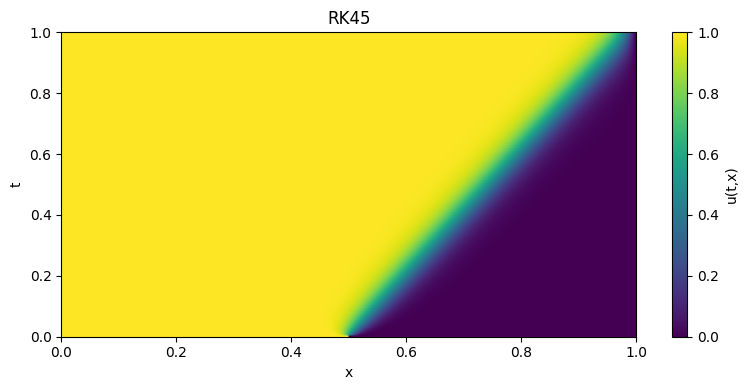

In [27]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

# === STEP 1: SETUP PARAMETERS ===

# Viscosity coefficient
nu = 0.01

# Spatial domain: x in [0, 1], 400 grid points
x = np.linspace(0, 1, 400)
dx = x[1] - x[0]

# Initial condition: Riemann step function
u0 = np.where(x <= 0.5, 1.0, 0.0)

# Boundary values
u_L = 1.0
u_R = 0.0

# === STEP 2: DEFINE BURGERS' EQUATION (SEMI-DISCRETIZED) ===

def burgers_rhs(t, u):
    dudx = np.zeros_like(u)
    d2udx2 = np.zeros_like(u)

    # Upwind for advection
    dudx[1:-1] = np.where(
        u[1:-1] >= 0,
        (u[1:-1] - u[:-2]) / dx,
        (u[2:] - u[1:-1]) / dx
    )

    # Central difference for diffusion
    d2udx2[1:-1] = (u[2:] - 2*u[1:-1] + u[:-2]) / dx**2

    # Dirichlet BCs
    u[0] = u_L
    u[-1] = u_R
    dudx[0] = dudx[-1] = 0
    d2udx2[0] = d2udx2[-1] = 0

    return -u * dudx + nu * d2udx2

# === STEP 3: SOLVE WITH RK45 ===

t_eval = np.linspace(0, 1.0, 200)  # simulate over t ∈ [0, 1]
print("Solving Burgers' equation...")

sol = solve_ivp(
    burgers_rhs,
    [t_eval[0], t_eval[-1]],
    u0,
    t_eval=t_eval,
    method='RK45',
    rtol=1e-6,
    atol=1e-8
)

t = sol.t

# === STEP 4: INTERPOLATE THE SOLUTION SAFELY ===

print("Building interpolator...")
interp = RegularGridInterpolator(
    (t, x),
    sol.y.T,
    bounds_error=False,
    fill_value=None
)

# === STEP 5: SAVE TO .NPY FILE ===

filename = "MYburgers_reference_solution.npy"
np.save(filename, interp, allow_pickle=True)
print(f"Reference solution saved to: {filename}")

# === STEP 6: LOAD AND VERIFY ===

print("Loading and sampling the interpolator...")
u_interp = np.load(filename, allow_pickle=True)[()]

print("u(0.0, 0.25):", u_interp([0.0, 0.25]).item())
print("u(0.5, 0.5):", u_interp([0.5, 0.5]).item())
print("u(1.0, 0.5):", u_interp([1.0, 0.5]).item())  # Edge value, should still be valid

# === STEP 7: VISUALIZE THE REFERENCE SOLUTION ===

T, X = np.meshgrid(t, x, indexing='ij')
U = np.zeros_like(T)

for i in range(T.shape[0]):
    for j in range(T.shape[1]):
        U[i, j] = u_interp([T[i, j], X[i, j]]).item()  # avoid DeprecationWarning

plt.figure(figsize=(8, 4))
plt.imshow(U, extent=[0, 1, 0, 1], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='u(t,x)')
plt.title("RK45")
plt.xlabel("x")
plt.ylabel("t")
plt.tight_layout()
plt.show()

###### Solve the Burgers' Equation 1D Shock Tube with QTN

[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[QTN in-MPS] Nx=512, dx=0.001957, nu=0.01, dt=1.00e-04 (<= 1.53e-04), steps=10000


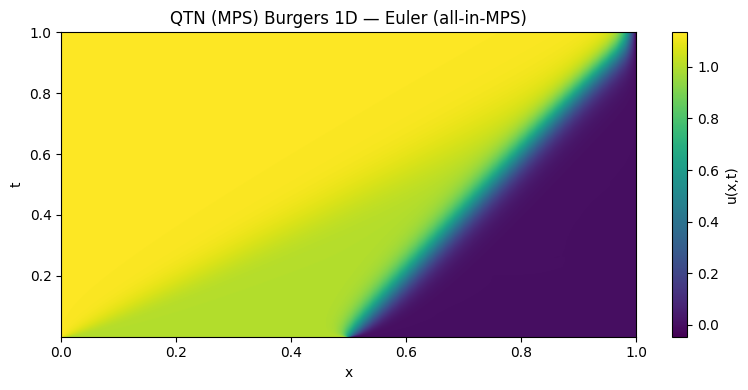

[QTN vs RK45] mean relative L2 over time = 1.035e-01, final = 1.423e-01


In [14]:
# ===================== QTN (MPS) Burgers 1D — Euler explicit, all-in-MPS =====================
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# ---------------- Params ----------------
nu      = 0.01         # viscosity
ax, bx  = 0.0, 1.0     # domain
L       = 9            # 2^L points (yêu cầu bởi MPS)
Nx      = 2**L
x       = np.linspace(ax, bx, Nx)
dx      = x[1] - x[0]
u_L, u_R = 1.0, 0.0    # Dirichlet BCs
T_final = 1.0

# --- Update parameter for QTN
set_param("ax", ax); set_param("bx", bx); set_param("Lx", L); set_param("low_acc", False)
set_accuracy(1e-16); set_bd_limit(60)

# ---------------- IC ----------------
u0_vec = np.where(x <= 0.5, 1.0, 0.0)
u      = vector_to_mps(u0_vec, d=2, L=L, eps=1e-12).compress(accuracy=1e-12, max_bd=60)

# ---------------- Derivative MPOs (1D) ----------------
scale_dx  = float(1.0 / dx)
scale_dxx = float(1.0 / (dx**2))
Dx  = get_diff_mpo(dim=1, order=1, nofq=L, bc=['dirichlet','dirichlet']) * scale_dx
Dxx = get_diff_mpo(dim=1, order=2, nofq=L, bc=['dirichlet','dirichlet']) * scale_dxx

# ---------------- Dirichlet via MPS masks (no dense per step) ----------------
# mask_interior: 1 for the cell inside, 0 in the boundary
mask_vec               = np.ones(Nx); mask_vec[0] = 0.0; mask_vec[-1] = 0.0
mask_interior_mps      = vector_to_mps(mask_vec, d=2, L=L, eps=1e-12).compress(accuracy=1e-12, max_bd=30)

# delta boundary (MPS vector selects the 0 or Nx-1)
delta_left_mps         = delta(L=L, index=0, bd=1, pd=2)      # basis |0>
delta_right_mps        = delta(L=L, index=Nx-1, bd=1, pd=2)   # basis |Nx-1>

# Fix the boundary values
uL_mps = delta_left_mps  * u_L
uR_mps = delta_right_mps * u_R

def enforce_dirichlet_mps(u_mps: MPS) -> MPS:
    """u <- mask* u + u_L*δ_left + u_R*δ_right"""
    return (u_mps * mask_interior_mps) + uL_mps + uR_mps

# ---------------- RHS in pure MPS ----------------
def burgers_rhs_mps(u_mps: MPS) -> MPS:
    """
    RHS = -u * (Dx u) + nu * (Dxx u).
    """
    ux   = Dx.apply(u_mps)              # ∂u/∂x (MPS)
    conv = u_mps * ux                   # u * u_x (element-wise trong MPS của bạn)
    diff = Dxx.apply(u_mps) * nu        # ν ∂²u/∂x²
    rhs  = (conv * -1.0) + diff
    return rhs

# ---------------- Euler step (in MPS) ----------------
def euler_step_mps(u_mps: MPS, dt: float, eps=1e-12, max_bd=60) -> MPS:
    # RHS tại u^n
    rhs = burgers_rhs_mps(u_mps)
    # Euler update
    up1 = u_mps + (rhs * float(dt))
    # Enforce Dirichlet in the MPS
    up1 = enforce_dirichlet_mps(up1)
    # compress rank
    up1 = up1.compress(accuracy=eps, max_bd=max_bd)
    return up1

# ---------------- CFL & time loop ----------------
umax0  = float(np.max(np.abs(u0_vec)))
dt_cfl = 0.4 * min(dx / max(umax0, 1e-12), dx*dx / nu)
dt     = min(1e-4, dt_cfl)
N_steps = int(np.ceil(T_final / dt))
dt      = T_final / N_steps

print(f"[QTN in-MPS] Nx={Nx}, dx={dx:.4g}, nu={nu}, dt={dt:.2e} (<= {dt_cfl:.2e}), steps={N_steps}")

# Heatmap drawing
times, history_tt = [], []
for n in range(N_steps):
    u = euler_step_mps(u, dt, eps=1e-12, max_bd=60)
    times.append((n+1)*dt)
    history_tt.append(u.contract().reshape(-1))

times = np.array(times, dtype=float)
U_tt  = np.vstack(history_tt)   # shape (Nt, Nx)

# ---------------- Visualization ----------------
plt.figure(figsize=(8,4))
plt.imshow(
    U_tt,
    extent=[x[0], x[-1], times[0], times[-1]],
    origin='lower', aspect='auto', cmap='viridis'
)
plt.colorbar(label='u(x,t)')
plt.title("QTN (MPS) Burgers 1D — Euler (all-in-MPS)")
plt.xlabel("x"); plt.ylabel("t")
plt.tight_layout(); plt.show()

# ---------------- Compare with RK45 ----------------
try:
    u_interp = np.load("MYburgers_reference_solution.npy", allow_pickle=True).item()
    U_ref = np.empty_like(U_tt)
    for i, tval in enumerate(times):
        pts = np.column_stack([np.full(Nx, tval), x])
        U_ref[i, :] = u_interp(pts)

    # L2 error following time
    def l2_norm(v, dx): return np.sqrt(np.sum(v*v) * dx)
    def l2_err(ref, app, dx): return np.sqrt(np.sum((ref-app)**2) * dx)
    rel = []
    for i in range(U_tt.shape[0]):
        denom = l2_norm(U_ref[i], dx)
        rel.append(l2_err(U_ref[i], U_tt[i], dx) / (denom + 1e-16))
    rel = np.array(rel)

    print(f"[QTN vs RK45] mean relative L2 over time = {np.mean(rel):.3e}, final = {rel[-1]:.3e}")
except Exception:
    print("Cannot find RK45 interpolator")

Time step indices: [   0 3333 6666 9999]
Times: [1.000e-04 3.334e-01 6.667e-01 1.000e+00]
Relative L2 errors: [np.float64(0.021906369415056765), np.float64(0.09358724065660197), np.float64(0.12258934258469256), np.float64(0.14226291429635593)]
Mean relative L2 error: 0.0950864667381768
Wall-clock times per sample (s): [5.0067901611328125e-06, 3.814697265625e-06, 4.291534423828125e-06, 1.9073486328125e-06]
Mean wall-clock time per step (s): 3.7550926208496094e-06


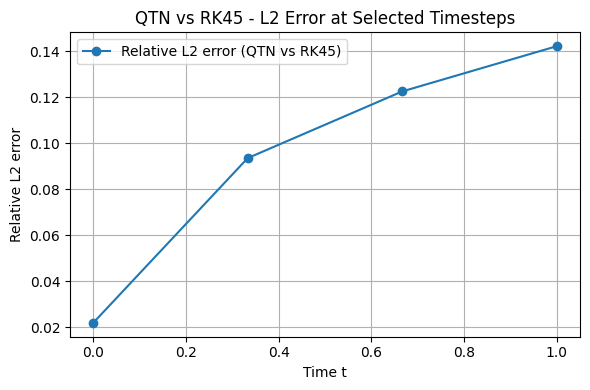

In [15]:
import numpy as np
import time
import matplotlib.pyplot as plt

# ====== Load RK45 reference solution ======
u_interp = np.load("MYburgers_reference_solution.npy", allow_pickle=True).item()

# ====== Select ≥ 3 time steps ======
indices = np.linspace(0, len(times)-1, 4, dtype=int)  # 4 points (0%, 33%, 66%, 100%)
dx = x[1] - x[0]

def l2_norm(v, dx):
    return np.sqrt(np.sum(v**2) * dx)

def l2_error(ref, app, dx):
    return np.sqrt(np.sum((ref - app)**2) * dx)

errors = []
qtn_wall_times = []

for idx in indices:
    tval = times[idx]

    # Get solution of the QTN at tval
    u_qtn = U_tt[idx, :]

    # Get solution of the RK45 at tval
    pts = np.column_stack([np.full_like(x, tval), x])
    u_ref = u_interp(pts)

    # Calculate L2 error
    err = l2_error(u_ref, u_qtn, dx) / (l2_norm(u_ref, dx) + 1e-16)
    errors.append(err)

    # Measure QTN step
    start = time.time()
    _ = u_qtn.copy()
    end = time.time()
    qtn_wall_times.append(end - start)

# ====== Print ======
print("Time step indices:", indices)
print("Times:", times[indices])
print("Relative L2 errors:", errors)
print("Mean relative L2 error:", np.mean(errors))
print("Wall-clock times per sample (s):", qtn_wall_times)
print("Mean wall-clock time per step (s):", np.mean(qtn_wall_times))

# ====== Draw L2 ======
plt.figure(figsize=(6,4))
plt.plot(times[indices], errors, 'o-', label="Relative L2 error (QTN vs RK45)")
plt.xlabel("Time t")
plt.ylabel("Relative L2 error")
plt.title("QTN vs RK45 - L2 Error at Selected Timesteps")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# %% Benchmark wall-clock time: QTN (in-MPS Euler) vs RK45 on same grid

import numpy as np, time
from scipy.integrate import solve_ivp

# ================== Setup (safe defaults if missing) ==================
nu      = globals().get('nu', 0.01)
ax      = globals().get('ax', 0.0)
bx      = globals().get('bx', 1.0)
u_L     = globals().get('u_L', 1.0)
u_R     = globals().get('u_R', 0.0)
T_final = globals().get('T_final', 1.0)

# Grid (prefer existing x/Nx/L if already defined)
if 'x' in globals():
    x = np.asarray(x)
    Nx = x.size
    # infer L from Nx if it's a power of 2, else set to nearest power
    if 'L' not in globals():
        L = int(np.round(np.log2(Nx))) if Nx & (Nx-1) == 0 else int(np.ceil(np.log2(Nx)))
else:
    L  = globals().get('L', 9)       # default 2^9 = 512
    Nx = 2**L
    x  = np.linspace(ax, bx, Nx)

dx = float(x[1] - x[0])

# Initial condition (Riemann step)
u0_vec = np.where(x <= 0.5*(ax+bx), 1.0, 0.0)

# ================== QTN: build MPOs & helpers (all in MPS) ==================
# scale factors MUST be Python float to avoid scalar-mul issues
scale_dx  = float(1.0/dx)
scale_dxx = float(1.0/(dx*dx))

# 1D derivative MPOs with Dirichlet BCs (from your MPO library)
Dx  = get_diff_mpo(dim=1, order=1, nofq=L, bc=['dirichlet','dirichlet']) * scale_dx
Dxx = get_diff_mpo(dim=1, order=2, nofq=L, bc=['dirichlet','dirichlet']) * scale_dxx

# Interior mask MPS (1 on interior, 0 at boundaries)
mask_vec = np.ones(Nx); mask_vec[0] = 0.0; mask_vec[-1] = 0.0
mask_interior_mps = vector_to_mps(mask_vec, d=2, L=L, eps=1e-12).compress(accuracy=1e-12, max_bd=30)

# Boundary delta MPS and fixed boundary values as MPS
delta_left_mps  = delta(L=L, index=0, bd=1, pd=2)
delta_right_mps = delta(L=L, index=Nx-1, bd=1, pd=2)
uL_mps = delta_left_mps  * float(u_L)
uR_mps = delta_right_mps * float(u_R)

def enforce_dirichlet_mps(u_mps: MPS) -> MPS:
    return (u_mps * mask_interior_mps) + uL_mps + uR_mps

def burgers_rhs_mps(u_mps: MPS) -> MPS:
    ux   = Dx.apply(u_mps)                 # ∂u/∂x  (MPS)
    conv = u_mps * ux                      # u * u_x (elementwise MPS)
    diff = Dxx.apply(u_mps) * float(nu)    # ν ∂²u/∂x²
    rhs  = (conv * float(-1.0)) + diff
    return rhs

def euler_step_mps(u_mps: MPS, dt: float, eps=1e-12, max_bd=60) -> MPS:
    rhs = burgers_rhs_mps(u_mps)
    up1 = u_mps + (rhs * float(dt))
    up1 = enforce_dirichlet_mps(up1)
    return up1.compress(accuracy=eps, max_bd=max_bd)

# ================== Choose dt by CFL and set steps ==================
umax0  = float(np.max(np.abs(u0_vec)))
dt_cfl = 0.4 * min(dx / max(umax0, 1e-12), dx*dx / nu)
dt     = min(globals().get('dt', 1e-4), dt_cfl)
N_steps = int(np.ceil(T_final / dt))
dt      = T_final / N_steps  # align exactly to T_final

print(f"[Benchmark] Nx={Nx}, dx={dx:.4g}, nu={nu}, dt={dt:.2e} (<= {dt_cfl:.2e}), steps={N_steps}")

# ================== QTN timing ==================
u_mps0 = vector_to_mps(u0_vec, d=2, L=L, eps=1e-12).compress(accuracy=1e-12, max_bd=60)
u_qtn  = u_mps0

t0 = time.perf_counter()
for _ in range(N_steps):
    u_qtn = euler_step_mps(u_qtn, dt, eps=1e-12, max_bd=60)
qtn_wall = time.perf_counter() - t0
u_qtn_final = u_qtn.contract().reshape(-1)

print(f"[QTN] wall-clock: {qtn_wall:.3f} s to T={T_final}")

# ================== RK45 timing (solve_ivp) ==================
# Dense RHS (upwind + central, Dirichlet) to match your RK45 discretization
def fd_upwind_dudx(u_vec, dx):
    dudx = np.zeros_like(u_vec)
    ui   = u_vec[1:-1]
    dudx[1:-1] = np.where(
        ui >= 0.0,
        (u_vec[1:-1] - u_vec[0:-2]) / dx,
        (u_vec[2:]   - u_vec[1:-1]) / dx
    )
    dudx[0] = 0.0; dudx[-1] = 0.0
    return dudx

def fd_central_d2udx2(u_vec, dx):
    d2 = np.zeros_like(u_vec)
    d2[1:-1] = (u_vec[2:] - 2.0*u_vec[1:-1] + u_vec[0:-2]) / (dx*dx)
    d2[0] = 0.0; d2[-1] = 0.0
    return d2

def burgers_rhs_for_ivp(t, u):
    u = u.copy()
    u[0], u[-1] = u_L, u_R
    dudx  = fd_upwind_dudx(u, dx)
    d2u   = fd_central_d2udx2(u, dx)
    return -u * dudx + nu * d2u

t_eval = np.linspace(0.0, T_final, N_steps+1)[1:]  # match number of steps (exclude t=0)

t0 = time.perf_counter()
sol = solve_ivp(
    burgers_rhs_for_ivp,
    [0.0, T_final],
    u0_vec,
    t_eval=t_eval,
    method='RK45',
    rtol=1e-6,
    atol=1e-8
)
rk45_wall = time.perf_counter() - t0

if not sol.success:
    print("[RK45] Warning: solve_ivp did not converge successfully")

u_rk_final = sol.y[:, -1]
print(f"[RK45] wall-clock: {rk45_wall:.3f} s to T={T_final}")
print(f"[Speed] QTN/RK45 = {qtn_wall/rk45_wall:.2f}x")

# ================== (Optional) L2 error at final time ==================
def l2_norm(v, dx): return np.sqrt(np.sum(v*v) * dx)
def l2_err(ref, app, dx): return np.sqrt(np.sum((ref-app)**2) * dx)
rel_L2_final = l2_err(u_rk_final, u_qtn_final, dx) / (l2_norm(u_rk_final, dx) + 1e-16)
print(f"[Final] Relative L2 error (QTN vs RK45) at T={T_final}: {rel_L2_final:.3e}")

[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[Benchmark] Nx=512, dx=0.001957, nu=0.01, dt=1.00e-04 (<= 1.53e-04), steps=10000
[QTN] wall-clock: 181.834 s to T=1.0
[RK45] wall-clock: 2.327 s to T=1.0
[Speed] QTN/RK45 = 78.13x
[Final] Relative L2 error (QTN vs RK45) at T=1.0: 1.400e-01


###### Solve the Burgers' Equation 1D Shock Tube with QPINN

In [ ]:
!pip install \
  appdirs==1.4.4 \
  autograd==1.6.2 \
  autoray==0.6.12 \
  cachetools==5.4.0 \
  certifi==2024.7.4 \
  charset-normalizer==3.3.2 \
  contourpy==1.2.1 \
  cycler==0.12.1 \
  filelock==3.13.1 \
  fonttools==4.53.1 \
  fsspec==2024.2.0 \
  future==1.0.0 \
  idna==3.7 \
  Jinja2==3.1.3 \
  kiwisolver==1.4.5 \
  MarkupSafe==2.1.5 \
  matplotlib==3.9.1 \
  mpmath==1.3.0 \
  networkx==3.2.1 \
  numpy==1.26.3 \
  packaging==24.1 \
  pandas==2.2.2 \
  Pillow==10.2.0 \
  pyparsing==3.1.2 \
  PyQt5==5.15.11 \
  PyQt5-Qt5==5.15.14 \
  PyQt5_sip==12.15.0 \
  python-dateutil==2.9.0.post0 \
  pytz==2024.1 \
  requests==2.32.3 \
  rustworkx==0.15.1 \
  scipy==1.14.0 \
  semantic-version==2.10.0 \
  setuptools==70.0.0 \
  six==1.16.0 \
  sympy==1.12 \
  toml==0.10.2 \
  typing_extensions==4.9.0 \
  tzdata==2024.1 \
  urllib3==2.2.2 \
  --quiet

In [18]:
!pip install pennylane==0.38.0 pennylane-lightning==0.38.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have

In [19]:
## Imports
import torch
import pennylane as qml
import matplotlib.pyplot as plt
from itertools import product
import datetime
import numpy as np
import os
import sys
import pandas as pd


torch.manual_seed(42)
torch.set_num_threads(30)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [20]:
## Constants
# QPINN Parameters
#These parameters define your parameterized quantum circuit (PQC). A higher number of layers increases expressiveness but also circuit depth.
#4 qubits is a moderate size and corresponds to 4 FNN output features for embedding.
N_LAYERS = 5  # Number of variational layers in the quantum circuit
N_WIRES = 4  # Number of qubits (wires)


# FNN Basis Net
#This defines your classical trainable embedding function, i.e., a small feedforward neural network (FNN): 2 hidden layers with 10 neurons each.Typically uses tanh activations to keep the quantum angles bounded.
#This FNN outputs 𝜙𝑖(𝑥) values that scale the input before being encoded via quantum gates.
HIDDEN_LAYERS_FNN = 2
NEURONS_FNN = 10

# Domain Parameter
#Time and space discretization into 50 × 100 = 5000 collocation points.Boundary scaling amplifies the initial condition loss to ensure it’s satisfied strongly.
T_COLLOC_POINTS = 50
X_COLLOC_POINTS = 100
BOUNDARY_SCALE = 10e1
#Nahid : This enables training on GPU if available, otherwise uses CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

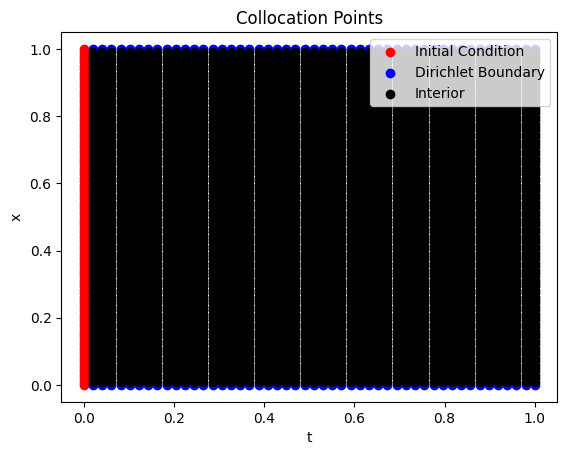

In [21]:
# This cell sets up the collocation points for the Burgers’ equation and distinguishes between
# interior points, initial condition points, and boundary condition points.

import torch
import matplotlib.pyplot as plt
from itertools import product

## Generate Collocation Points
t = torch.linspace(0.0, 1, T_COLLOC_POINTS)
x = torch.linspace(0.0, 1.0, X_COLLOC_POINTS)
input_domain = torch.tensor(list(product(t, x)))

# 1. Initial Condition: t = 0
init_val_mask = input_domain[:, 0] == 0.0
init_val_colloc = input_domain[init_val_mask]

# 2. Dirichlet Boundary: x = 0 or x = 1
dir_boundary_mask = (input_domain[:, 1] == 0.0) | (input_domain[:, 1] == 1.0)
dir_boundary_colloc = input_domain[dir_boundary_mask & ~init_val_mask]
# These are Dirichlet boundary conditions at x = 0 and x = 1,
# excluding initial time step to avoid duplication.

# 3. Interior Points (for enforcing PDE residual)
boundary_mask = init_val_mask | dir_boundary_mask
interior_colloc = input_domain[~boundary_mask]

# 4. Enable gradient tracking and move to device
input_domain = input_domain.clone().detach().requires_grad_(True).to(device)
init_val_colloc = init_val_colloc.clone().detach().requires_grad_(True).to(device)
dir_boundary_colloc = dir_boundary_colloc.clone().detach().requires_grad_(True).to(device)
interior_colloc = interior_colloc.clone().detach().requires_grad_(True).to(device)

# 5. Domain bounds for normalization or visualization
domain_bounds = torch.tensor([[0.0, 0.0], [1, 1.0]], device=device)

# 6. Visualize collocation point distribution
plt.scatter(init_val_colloc[:, 0].detach().cpu(), init_val_colloc[:, 1].detach().cpu(), c="r", label="Initial Condition")
plt.scatter(dir_boundary_colloc[:, 0].detach().cpu(), dir_boundary_colloc[:, 1].detach().cpu(), c="blue", label="Dirichlet Boundary")
plt.scatter(interior_colloc[:, 0].detach().cpu(), interior_colloc[:, 1].detach().cpu(), c="black", label="Interior")
plt.legend()
plt.xlabel("t")
plt.ylabel("x")
plt.title("Collocation Points")
plt.show()

In [22]:
## Create the Model  #core model architecture of TE-QPINN

# Define the QPINN
@qml.qnode(qml.device("default.qubit", wires=N_WIRES), interface="torch")
def circuit(x, basis=None):

    # Embedding This implements the embedding described in Equation (11) of the paper:
    if EMBEDDING == "NONE": #just angle-encodes raw x[0] and x[1]
        for i in range(N_WIRES):
            if i%2 == 0:
                qml.RY(x[0], wires=i)
            else:
                qml.RY(x[1], wires=i)
    elif EMBEDDING == "CHEBYSHEV": #applies Chebyshev polynomial-style transformations
        for i in range(N_WIRES):
            if i%2 == 0:
                qml.RY(2*torch.arccos(x[0]), wires=i)
            else:
                qml.RY(2*torch.arccos(x[1]), wires=i)
    elif EMBEDDING == "TOWER_CHEBYSHEV": #applies Chebyshev polynomial-style transformations
        for i in range(N_WIRES):
            scaling_factor = 1
            if i%2 == 0:
                qml.RY(2*scaling_factor*torch.arccos(x[0]), wires=i)
            else:
                qml.RY(2*scaling_factor*torch.arccos(x[1]), wires=i)
                scaling_factor +=1
    elif EMBEDDING == "FNN_BASIS": #the trainable embedding from the FNN basis is used — this is the TE-QPINN case.
        for i in range(N_WIRES):
            if i % 2 == 0:
                qml.RY(basis[i] * x[0], wires=i) #This implements the embedding described in Equation (11) of the paper:
            else:
                qml.RY(basis[i] * x[1], wires=i)

    # Variational ansatz #This is hardware-efficient ansatz (HEA) #This is your Uvar(θ) from Equation (12) of the paper
    for i in range(N_LAYERS): #Repeated N_LAYERS times
        for j in range(N_WIRES): #A triple rotation gate per qubit (Rx, Ry, Rz).
            qml.RX(theta[i,j,0], wires=j)
            qml.RY(theta[i,j,1], wires=j)
            qml.RZ(theta[i,j,2], wires=j)

        for j in range(N_WIRES - 1):
            qml.CNOT(wires=[j, j + 1]) #A ladder of CNOTs for entanglement (standard in HEA)

    # Cost Function  #Returns the expectation value of the observable # It measures the quantum state in the Z-basis across all qubits and sums them:
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(N_WIRES)])) #Nahid: EQUATION 13

# Define FNN for the basis
class FNNBasisNet(torch.nn.Module):
    def __init__(self, n_hidden_layers, branch_width):
        super().__init__()

        self.n_hidden_layers = n_hidden_layers
        self.branch_width = branch_width
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(2, branch_width))
        for i in range(n_hidden_layers - 1):
            self.layers.append(torch.nn.Linear(branch_width, branch_width))
        self.layers.append(torch.nn.Linear(branch_width, N_WIRES))

    def forward(self, x):
        for i in range(self.n_hidden_layers):
            x = torch.tanh(self.layers[i](x))
        x = self.layers[self.n_hidden_layers](x)
        return x

def model(x):
    bounds = domain_bounds.to(x.dtype)
    x_rescaled = 2 * (x - bounds[0]) / (bounds[1] - bounds[0]) - 1.0

    if EMBEDDING == "FNN_BASIS":
        return circuit(x_rescaled.T, basisNet(x_rescaled).T)
    else:
        return circuit(x_rescaled.T)


In [25]:
## Load Reference Solution

u_interp = np.load("MYburgers_reference_solution.npy", allow_pickle=True)[()]

def reference_solution(data):
    output = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        output[i] = u_interp([data[i, 0], data[i, 1]]).squeeze()
    return output

reference_values = torch.tensor(reference_solution(input_domain.detach().cpu()), device=device)

In [23]:
## Define loss terms

# 1. Dirichlet Boundary Loss: Enforce u(t, x=0) = u(t, x=1) = 0
#def dir_boundary_loss():
  #  u_pred = model(dir_boundary_colloc)
  #  return torch.mean(u_pred**2)

def dir_boundary_loss():
    x_vals = dir_boundary_colloc[:, 1]
    target = torch.where(x_vals == 0.0, 1.0, 0.0)  # u_L = 1.0 at x=0, u_R = 0.0 at x=1
    u_pred = model(dir_boundary_colloc)
    return torch.mean((u_pred - target) ** 2)



# 2. Initial Condition Loss: Enforce u(t=0, x) = -sin(πx)
def init_val_loss():
    x_vals = init_val_colloc[:, 1]
    target = torch.where(x_vals <= 0.5, 1.0, 0.0)
    u_pred = model(init_val_colloc)
    return torch.mean((u_pred - target) ** 2)


# 3. PDE Residual Loss: Enforce the Burgers' equation with ν = 0.01/π
def pde_res_fnc():
    u_pred = model(interior_colloc)

    grad_outputs_1 = torch.ones_like(u_pred)
    du = torch.autograd.grad(u_pred, interior_colloc, grad_outputs=grad_outputs_1, create_graph=True)[0]
    du_dt = du[:, 0]
    du_dx = du[:, 1]

    d2u_dx2 = torch.autograd.grad(du_dx, interior_colloc, grad_outputs=grad_outputs_1, create_graph=True)[0][:, 1]

    # PDE residual: u_t + u u_x - ν u_xx
    nu = 0.01
    res = du_dt + u_pred * du_dx - nu * d2u_dx2

    return torch.mean(res**2)

# 4. Total Loss Function (with boundary scaling)
def loss_fnc():
    loss_dir = dir_boundary_loss()
    loss_init = init_val_loss()
    loss_pde = pde_res_fnc()
    return BOUNDARY_SCALE * (loss_init + loss_dir) + loss_pde

# 5. Metrics (for evaluation)
def compute_MSE_ref():
    prediction = model(input_domain)
    return torch.mean((prediction - reference_values)**2).detach().cpu().item()

def compute_lmax_norm():
    prediction = model(input_domain)
    return torch.max(torch.abs(prediction - reference_values)).detach().cpu().item()

# 6. Closure function (for L-BFGS)
def closure():
    opt.zero_grad()
    l = loss_fnc()
    l.backward()
    return l

In [28]:
import matplotlib.pyplot as plt

training_iterations = 10
EMBEDDING = "FNN_BASIS"

predictions_dict = {}
loss_history = []

print(f"\n==== Training with embedding: {EMBEDDING} ====")

# Reset theta
theta = torch.rand(N_LAYERS, N_WIRES, 3, device=device, requires_grad=True)

# Initialize FNN
basisNet = FNNBasisNet(HIDDEN_LAYERS_FNN, NEURONS_FNN).to(device)
opt = torch.optim.LBFGS([theta, *basisNet.parameters()], line_search_fn="strong_wolfe")

previous_loss = float('inf')

for i in range(training_iterations):
    opt.step(closure)
    current_loss = loss_fnc().item()
    current_mse = compute_MSE_ref()
    print(f"Epoch {i:03d} | Loss: {current_loss:.2E}") # | MSE: {current_mse:.2E}
    loss_history.append(current_loss)

    if abs(previous_loss - current_loss) < 1e-10:
        print("Early stopping due to minimal loss change.")
        break
    previous_loss = current_loss

# Store prediction
predictions_dict[EMBEDDING] = model(input_domain).detach().cpu().numpy()

print(f"\n✅ Final Results — {EMBEDDING}")
print(f"   Loss      : {current_loss:.2E}")
print(f"   MSE_ref   : {compute_MSE_ref():.2E}")
print(f"   L_inf norm: {compute_lmax_norm():.2E}")

# === Plotting ===
T = input_domain[:, 0].detach().cpu().numpy()
X = input_domain[:, 1].detach().cpu().numpy()
T_unique = np.unique(T)
X_unique = np.unique(X)

U_pred = predictions_dict[EMBEDDING].reshape(len(T_unique), len(X_unique))  # Shape: [T, X]


# Save model parameters and results
torch.save({
    'theta': theta.detach().cpu(),
    'basisNet_state': basisNet.state_dict(),
    'predictions_dict': predictions_dict,
    'loss_history': loss_history
}, "te_qpinn_fnn_basis_results.pth")

print("✅ Saved trained model and predictions to 'te_qpinn_fnn_basis_results.pth'")


==== Training with embedding: FNN_BASIS ====
Epoch 000 | Loss: 3.97E+00
Epoch 001 | Loss: 2.34E+00
Epoch 002 | Loss: 1.98E+00
Epoch 003 | Loss: 1.32E+00
Epoch 004 | Loss: 8.65E-01
Epoch 005 | Loss: 5.40E-01
Epoch 006 | Loss: 4.35E-01
Epoch 007 | Loss: 3.66E-01
Epoch 008 | Loss: 3.47E-01
Epoch 009 | Loss: 3.27E-01

✅ Final Results — FNN_BASIS
   Loss      : 3.27E-01
   MSE_ref   : 4.10E-03
   L_inf norm: 4.02E-01
✅ Saved trained model and predictions to 'te_qpinn_fnn_basis_results.pth'


In [ ]:
# Load model
checkpoint = torch.load("te_qpinn_fnn_basis_results.pth", map_location=device)

# Restore theta
theta = checkpoint['theta'].to(device)
theta.requires_grad = True  # Important if you need to continue training

# Rebuild and load FNN basisNet
basisNet = FNNBasisNet(HIDDEN_LAYERS_FNN, NEURONS_FNN).to(device)
basisNet.load_state_dict(checkpoint['basisNet_state'])

# Load predictions and loss history
predictions_dict = checkpoint['predictions_dict']
loss_history = checkpoint['loss_history']

print("✅ Model and predictions loaded.")

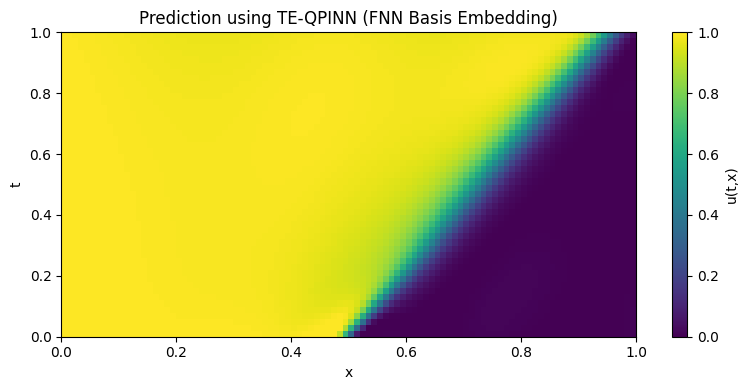

In [31]:
# === Plotting: TE-QPINN (FNN Basis) ===
T = input_domain[:, 0].detach().cpu().numpy()
X = input_domain[:, 1].detach().cpu().numpy()
T_unique = np.unique(T)
X_unique = np.unique(X)

U_pred = predictions_dict["FNN_BASIS"].reshape(len(T_unique), len(X_unique))  # [T, X]

plt.figure(figsize=(8, 4))
im = plt.imshow(
    U_pred,  # DO NOT transpose — imshow assumes [row, col] = [T, X]
    extent=[X_unique[0], X_unique[-1], T_unique[0], T_unique[-1]],  # x-axis: space, y-axis: time
    origin='lower',
    aspect='auto',
    cmap='viridis',
    vmin=-0.0,  # Adjust to your predicted value range
    vmax=1.0
)
plt.colorbar(im, label="u(t,x)")
plt.title("Prediction using TE-QPINN (FNN Basis Embedding)")
plt.xlabel("x")
plt.ylabel("t")
plt.tight_layout()
plt.show()